In [1]:
#!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
test = pd.read_csv('./data/test.csv')

In [4]:
# only refund date delete
df = pd.read_pickle('./data/data_3.pkl')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029111 entries, 827196 to 8856306
Data columns (total 41 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   month_id                     int8   
 1   shop_id                      int8   
 2   item_id                      int16  
 3   cnt_month                    float32
 4   city_id                      int8   
 5   cat_id                       int8   
 6   main_cat                     int8   
 7   sub_cat                      int8   
 8   year                         int16  
 9   month                        int8   
 10  sales_month                  int8   
 11  cnt_month_1                  float32
 12  cnt_month_2                  float32
 13  cnt_month_3                  float32
 14  cnt_month_6                  float32
 15  cnt_month_12                 float32
 16  item_id_mean_cnt_1           float32
 17  item_id_mean_cnt_2           float32
 18  item_id_mean_cnt_3           float32


In [6]:
df.head()

,month_id,shop_id,item_id,cnt_month,city_id,cat_id,main_cat,sub_cat,year,month,...,item_id/city_id_mean_cnt_1,item_id/city_id_mean_cnt_2,item_id/city_id_mean_cnt_3,item_id/city_id_mean_cnt_6,item_id/city_id_mean_cnt_12,shop_id/cat_id_mean_cnt_1,shop_id/cat_id_mean_cnt_2,shop_id/cat_id_mean_cnt_3,shop_id/cat_id_mean_cnt_6,shop_id/cat_id_mean_cnt_12
827196,3,25,8092,3.0,13,40,11,6,2013,4,...,1.000000,2.142857,0.0,0.0,0.0,1.087262,1.049296,0.0,0.0,0.0
827197,3,25,7850,3.0,13,30,8,54,2013,4,...,3.714286,2.285714,0.0,0.0,0.0,3.654494,2.279188,0.0,0.0,0.0
827198,3,25,8051,3.0,13,66,14,47,2013,4,...,0.000000,0.428571,0.0,0.0,0.0,1.827586,1.389474,0.0,0.0,0.0
827199,3,25,8088,1.0,13,55,13,4,2013,4,...,0.285714,0.000000,0.0,0.0,0.0,0.599845,0.562107,0.0,0.0,0.0
827200,3,25,8089,1.0,13,55,13,4,2013,4,...,0.571429,0.000000,0.0,0.0,0.0,0.599845,0.562107,0.0,0.0,0.0


In [7]:
s = ['cnt_month', 'cnt_month_1','cnt_month_2', 'cnt_month_3','cnt_month_6','cnt_month_12', 
     'item_id_mean_cnt_1','item_id_mean_cnt_2', 'item_id_mean_cnt_3', 'item_id_mean_cnt_6', 'item_id_mean_cnt_12',
     'sub_cat_mean_cnt_1','sub_cat_mean_cnt_2', 'sub_cat_mean_cnt_3', 'sub_cat_mean_cnt_6', 'sub_cat_mean_cnt_12',
     'price_mean_mean_cnt_1', 'price_mean_mean_cnt_2', 'price_mean_mean_cnt_3','price_mean_mean_cnt_6', 'price_mean_mean_cnt_12',
     'item_id/city_id_mean_cnt_1', 'item_id/city_id_mean_cnt_2', 'item_id/city_id_mean_cnt_3', 'item_id/city_id_mean_cnt_6', 'item_id/city_id_mean_cnt_12',
     'shop_id/cat_id_mean_cnt_1','shop_id/cat_id_mean_cnt_2', 'shop_id/cat_id_mean_cnt_3','shop_id/cat_id_mean_cnt_6','shop_id/cat_id_mean_cnt_12']

In [8]:
# value clip(0~20)
df[s] = df[s].clip(0, 20)

In [9]:
# train/validation/test data split
X_train = df[df['month_id'] < 33].drop(['cnt_month'], axis=1)
Y_train = df[df['month_id'] < 33]['cnt_month']

X_valid = df[df['month_id'] == 33].drop(['cnt_month'], axis=1)
Y_valid = df[df['month_id'] == 33]['cnt_month']

X_test = df[df['month_id'] == 34].drop(['cnt_month'], axis=1)

In [10]:
model = CatBoostRegressor(
    max_depth=10,              # 트리의 최대 깊이
    n_estimators = 1000,       # 최대 트리 수
    eta = 0.3,                 # 학습률 : 증감률을 줄이는데 사용
    random_seed=123            # 훈련에 사용되는 랜덤 시드
    )

In [11]:
ts = time.time()

model.fit(
    X_train, Y_train, 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],  # 유효성 검사 데이터 세트
    verbose=True,                                      # True : 상세로그수준 / False : 자동로그수준 / int : 상세로그수준을 사용, 매개변수로 로깅기간 사용 
    early_stopping_rounds = 20                         # 반복횟수 설정
    )

print('소요시간: ',time.time()-ts)

0:	learn: 1.0975231	test: 1.0975231	test1: 0.9789749	best: 0.9789749 (0)	total: 4.57s	remaining: 1h 16m
1:	learn: 1.0200803	test: 1.0200803	test1: 0.9174592	best: 0.9174592 (1)	total: 8.77s	remaining: 1h 12m 54s
2:	learn: 0.9753011	test: 0.9753011	test1: 0.8857734	best: 0.8857734 (2)	total: 13s	remaining: 1h 11m 47s
3:	learn: 0.9480792	test: 0.9480792	test1: 0.8670291	best: 0.8670291 (3)	total: 17.4s	remaining: 1h 12m 10s
4:	learn: 0.9325085	test: 0.9325085	test1: 0.8586737	best: 0.8586737 (4)	total: 22s	remaining: 1h 13m 2s
5:	learn: 0.9201402	test: 0.9201402	test1: 0.8486167	best: 0.8486167 (5)	total: 26.5s	remaining: 1h 13m 11s
6:	learn: 0.9138034	test: 0.9138034	test1: 0.8458072	best: 0.8458072 (6)	total: 30.8s	remaining: 1h 12m 50s
7:	learn: 0.9067239	test: 0.9067239	test1: 0.8359852	best: 0.8359852 (7)	total: 35.1s	remaining: 1h 12m 29s
8:	learn: 0.9022583	test: 0.9022583	test1: 0.8327070	best: 0.8327070 (8)	total: 39.5s	remaining: 1h 12m 29s
9:	learn: 0.8979996	test: 0.8979996	t

In [12]:
Y_pred = model.predict(X_valid)

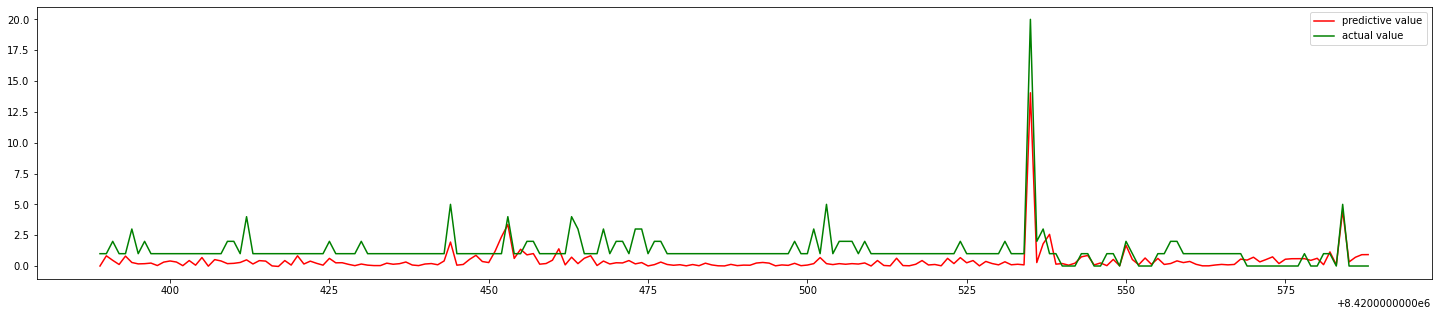

In [13]:
submission = pd.DataFrame({
    "ID": X_valid.index, 
    "item_cnt_month": Y_pred
})
x = submission['ID'].head(200)
y_pred = submission['item_cnt_month'].head(200)
y_true = Y_valid.head(200)
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x, y_pred, label = 'predictive value', color = 'red')
ax.plot(x, y_true, label = 'actual value', color = 'green')

ax.legend()

plt.show()

In [14]:
Y_test = model.predict(X_test)

In [15]:
# 제출 파일 생성
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./submission/submission_CatBoost_2022022805.csv', index=False)